In [1]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from helper import *

# VAEs on 2D Data
In this, we will train a simple VAE on 2D data.

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. 

Dataset 1


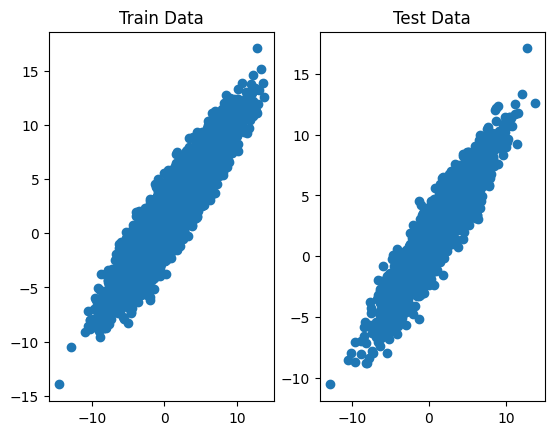

Dataset 2


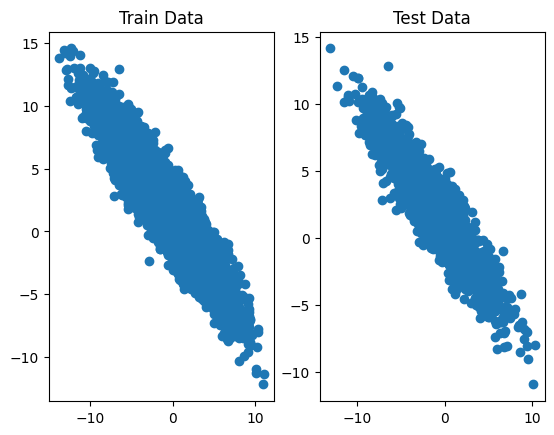

In [2]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**Over the course of training we will**


1.   Record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




In [3]:
def train(model, train_loader, optimizer, epoch, quiet, grad_clip=None):
    model.train()
    
    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        
        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'
            
        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
        
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item()*x.shape[0]
        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses
    
def train_epochs(model, train_loader, test_loader, train_args, quiet=False):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = OrderedDict(), OrderedDict()
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet, grad_clip)
        test_loss = eval_loss(model, test_loader, quiet)
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses

class MLP(nn.Module):
    # Creates an MLP with following nof. of neurons every layer and ReLU activation after every layer
    # 2 --> 128 --> 128 --> 4
    def __init__(self, input_shape, output_shape, hiddens=[]):
        super().__init__()
        
        if isinstance(input_shape, int):
            input_shape = (input_shape, )
        if isinstance(output_shape, int):
            output_shape = (output_shape, )
        
        self.input_shape = input_shape # 2
        self.output_shape = output_shape # 4
        self.hiddens = hiddens # [128, 128]
        
        model = []
        prev_h = np.prod(input_shape) # 2
        for h in hiddens + [np.product(output_shape)]:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.ReLU())
            prev_h = h
        model.pop()
        self.net = nn.Sequential(*model)
        
        
    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.net(x).view(b, *self.output_shape)
    
class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_hidden_sizes=[],
                 dec_hidden_sizes=[]):
        super().__init__()
        self.latent_dim = latent_dim # 2
        # output_dim = 4 -> mean and log(std) for each of 2 dimesions
        self.encoder = MLP(input_dim, 2*latent_dim, enc_hidden_sizes) # initialize MLP as encoder
        self.decoder = MLP(latent_dim, 2*input_dim, dec_hidden_sizes) # initialize MLP as decoder
    
    def loss(self, x):
        # self.encoder(x) --> (bs, 4)
        # feed observed variables to encoder
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1) # split predicted mean and std - (bs, 2), (bs, 2)
        z = torch.randn_like(mu_z)*log_std_z.exp() + mu_z # calculate z with extimated mean and std. We assumed q(z/x) to be Gaussian
        # feed latent variables to decoder
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1) # split predicted mean and std - (bs, 2), (bs, 2)
        
        # Compute reconstruction loss - Note that it may be easier for you
        # to use torch.distributions.normal to compute the log_prob
        
        # log(P(x/z))
        recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + \
                     (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5 # loss per dim: (bs, 2)
        recon_loss = recon_loss.sum(1).mean() # mean loss across batch

        # Compute KL - KL (q(z/x)|| P(Z)
        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5 # loss per dim: (bs, 2)
        kl_loss = kl_loss.sum(1).mean() # mean loss across batch
        
        # return different losses as a dictionary
        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)
    
    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda() # sample latent variables
            mu, log_std = self.decoder(z).chunk(2, dim=1) # pass through decoder to mean and std
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu # sample x from Normal distribution with predicted mean and std (We assume P(x/z) to be Gaussian
            else:
                z = mu
        return z.cpu().numpy()        

In [4]:

def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    # train data is of shape (10000, 2) and test data is of shaoe (2500, w2)
    model = FullyConnectedVAE(2, 2, [128, 128], [128, 128]).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=10, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

Final -ELBO: 4.4400, Recon Loss: 2.8205, KL Loss: 1.6195


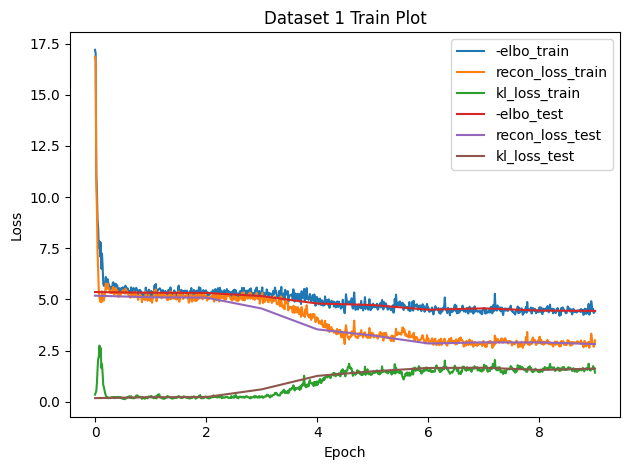

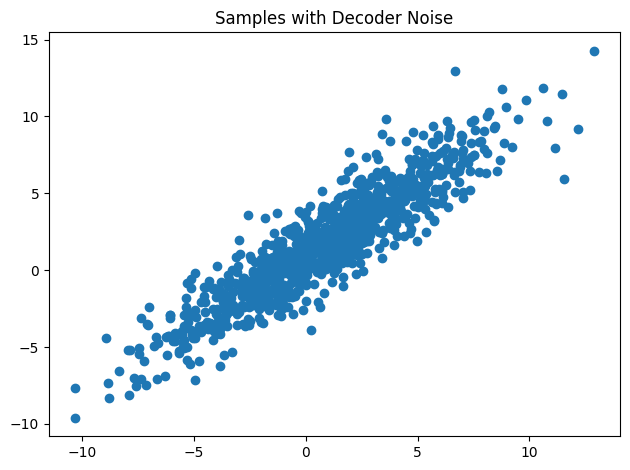

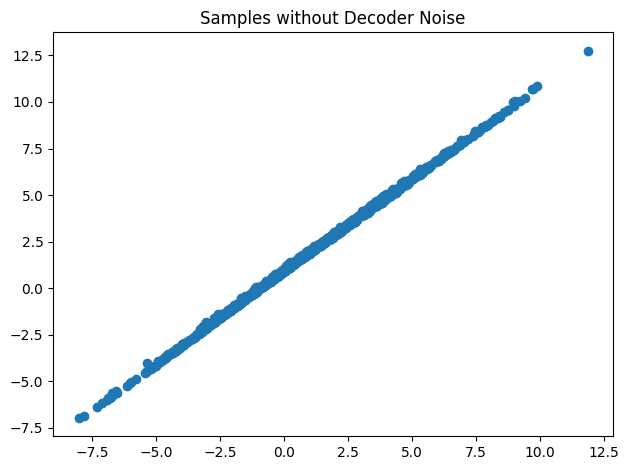

In [5]:
q1_save_results('a', 1, q1)
# note - KL loss (q(z/x) || p(z)) is not zero and we don't expect it as well 

Final -ELBO: 4.4354, Recon Loss: 2.8902, KL Loss: 1.5452


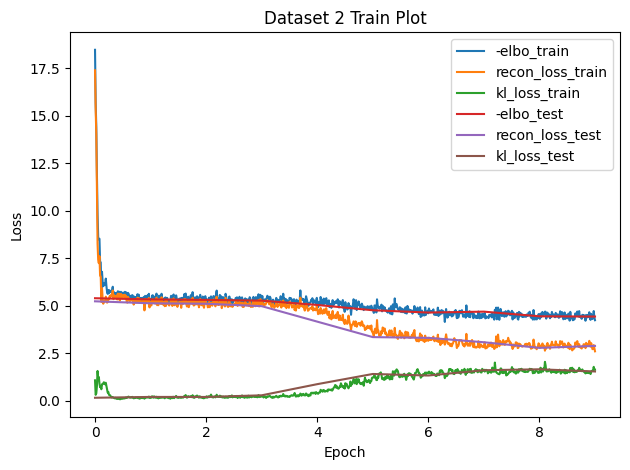

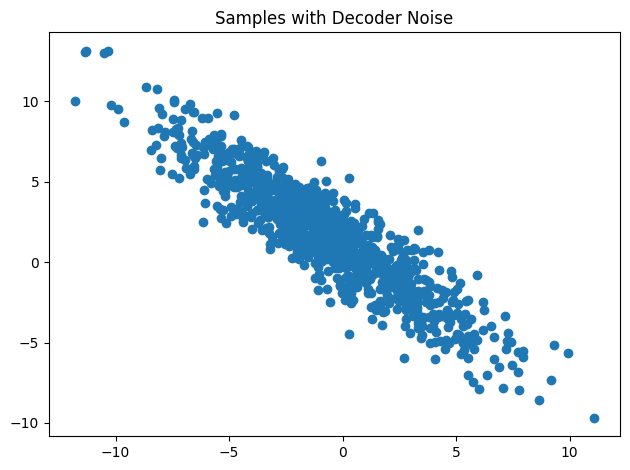

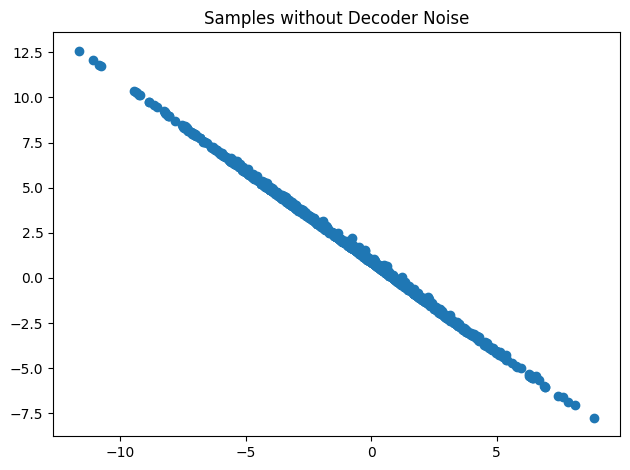

In [6]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian.

Dataset 1


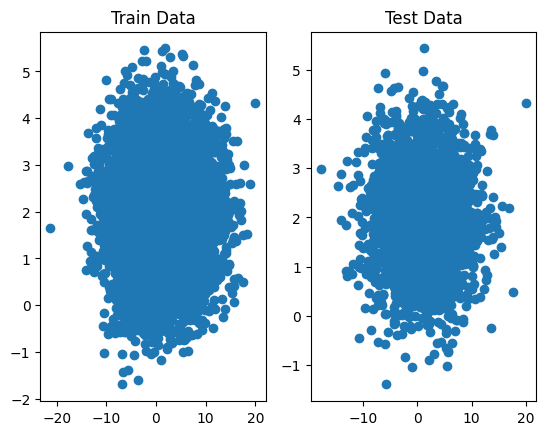

Dataset 2


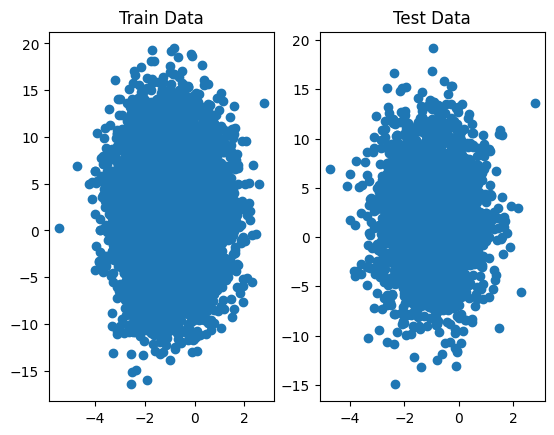

In [7]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

Final -ELBO: 4.4330, Recon Loss: 4.4218, KL Loss: 0.0112


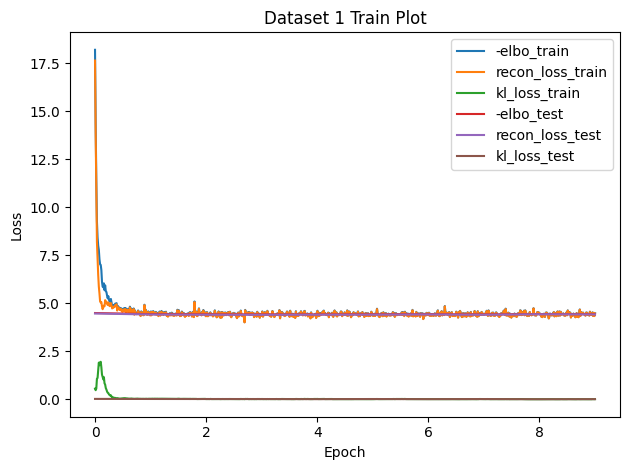

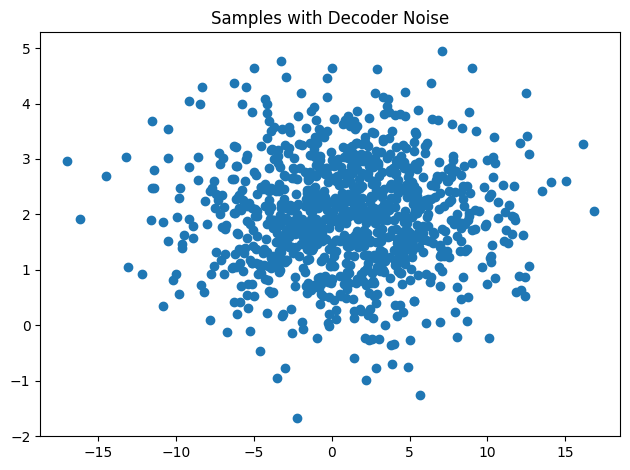

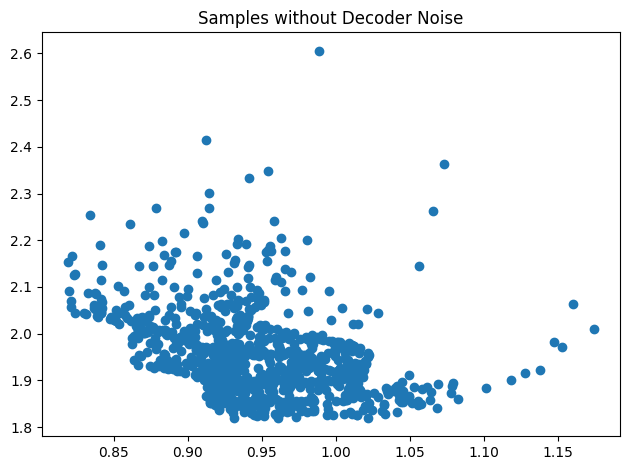

In [8]:
q1_save_results('b', 1, q1)


Final -ELBO: 4.4326, Recon Loss: 4.4154, KL Loss: 0.0172


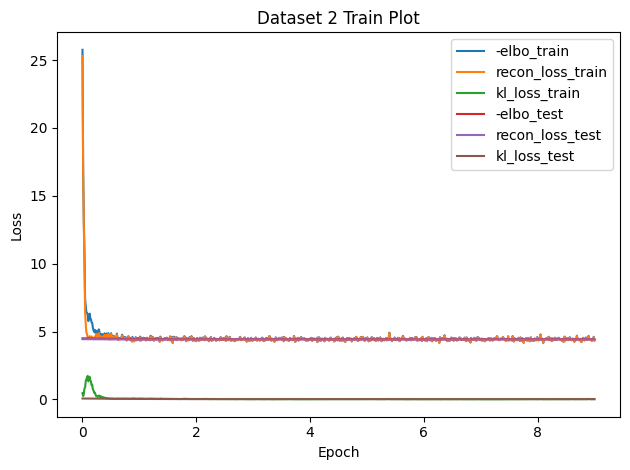

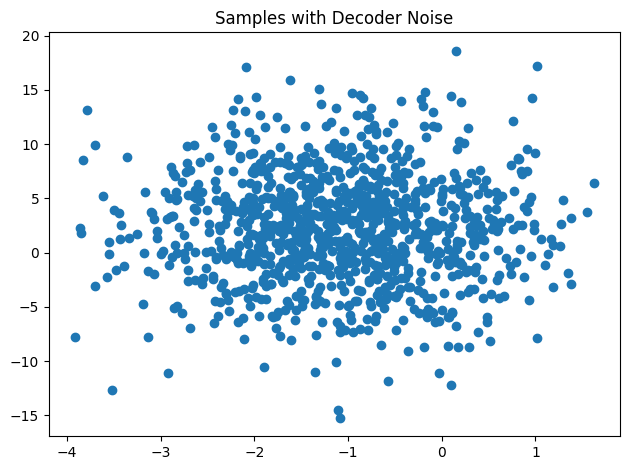

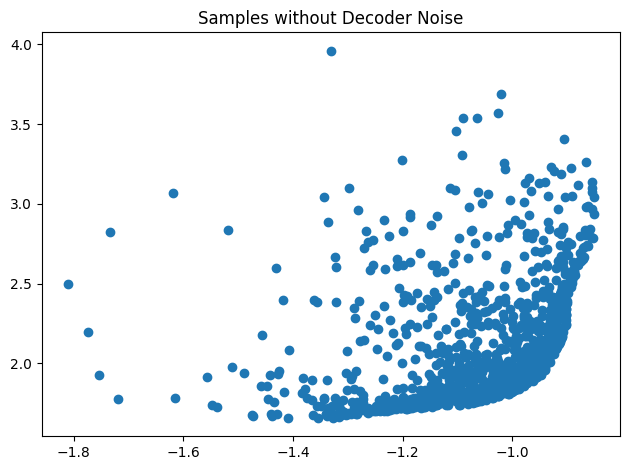

In [9]:
q1_save_results('b', 2, q1)


# Question 2: VAEs on Images

In this section, we will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).


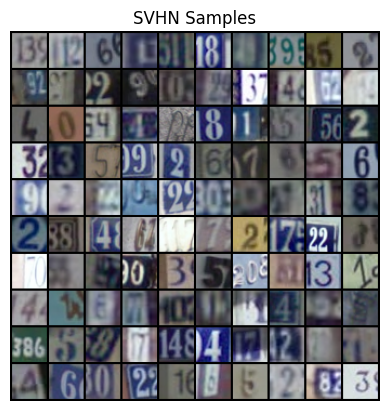

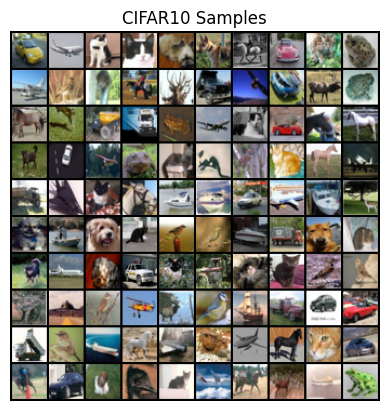

In [10]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE
In this part, we will implemet a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

We may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**Over the course of training we will**


1.  Record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



In [11]:
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_shape = output_shape
        
        self.base_size = (128, output_shape[1] // 8, output_shape[2] // 8) # (bs, 4, 4) = #(128, 4, 4)
        self.fc = nn.Linear(latent_dim, np.prod(self.base_size)) #(16, 2048)
        self.deconvs = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, output_shape[0], 3, padding=1),
        )
        
    def forward(self, z):
        # z: (128, 16)
        
        # (128, 2048)
        out = self.fc(z) 
        
        # reshape to (128, 128, 4, 4)
        out = out.view(out.shape[0], *self.base_size)
        
        # (128, 3, 32, 32)
        out = self.deconvs(out) 
        return out

class ConvEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.input_shape = input_shape #(3, 32, 32)
        self.latent_dim = latent_dim # 16
        # Conv network to encode image
        self.convs = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
        )
        conv_out_dim = input_shape[1] // 8 * input_shape[2] // 8 * 256 # 4096
        self.fc = nn.Linear(conv_out_dim, 2*latent_dim) # in_channels: 4096 --> out_channels: 32
        
    def forward(self, x):
        out = self.convs(x) # (bs, 4, 4, 256)
        out = out.view(out.shape[0], -1) # (bs, 4096)
        
        # self.fc(out) = (bs, 32) -> we have 16 latent variables, so we need a mu and log(std) for each variable
        mu, log_std = self.fc(out).chunk(2, dim=1) # (bs, 16), (bs, 16)
        return mu, log_std
    
class ConvVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3
        
        self.input_shape = input_shape # (3, 32, 32)
        self.latent_size = latent_size # 16
        self.encoder = ConvEncoder(input_shape, latent_size)
        self.decoder = ConvDecoder(latent_size, input_shape)
    
    def loss(self, x):
        x = 2*x - 1  #prep-processing
        # encoding step
        mu, log_std = self.encoder(x) # (bs, 16), (bs, 16)
        z = torch.randn_like(mu) * log_std.exp() + mu # sample z from Gaussian using predicted mean and std
        # reconstruction
        x_recon = self.decoder(z) # (bs, 3, 32, 32) 
        
        # recoontsruction loss takes as pixel wise MSE between original and reconstructed image
        recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(1).mean()
        
        # KL loss KL q(z/x)||P(z)
        kl_loss = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda() # sample 100 latent codes (100, 16)
            samples = torch.clamp(self.decoder(z), -1, 1) # feed to the decoder to get sample images (100, 3, 32, 32)
        return samples.cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5  # post process as during training x = 2*x + 1 was done (pre processing)
            

In [12]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """


    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32') #(10000, 3, 32, 32)
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32') # (5000, 3, 32, 32)

    model = ConvVAE((3, 32, 32), 16).cuda() #initialize VAE
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255. # sample 100 images
    
    # sample 100 inages for test set, encode and decode bacl
    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        x_recon = torch.clamp(model.decoder(z), -1, 1)
    reconstructions = torch.stack((x, x_recon), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    reconstructions = reconstructions.permute(0, 2, 3, 1).cpu().numpy() * 255
    
    # sample 20 images from test set
    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        # take the estimated mean as the sampled latent code 
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0) # latent codes of first and last 10 images, #(10, 16) #(10, 16)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)] # decode interpolated z
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    return train_losses, test_losses, samples, reconstructions, interps

Final -ELBO: 107.0769, Recon Loss: 83.4930, KL Loss: 23.5840


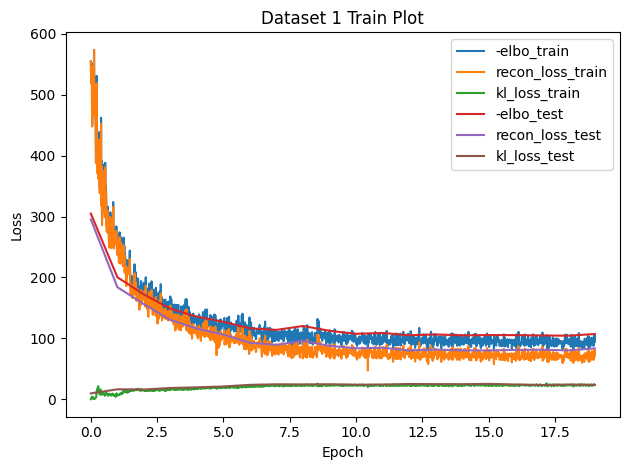

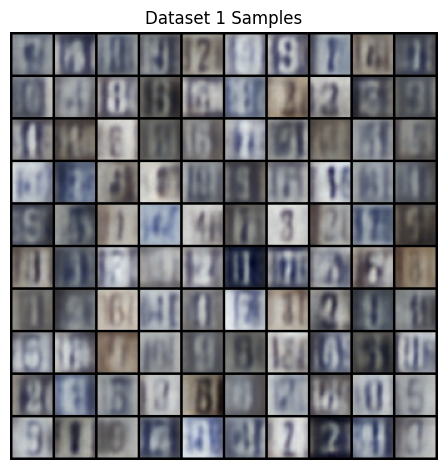

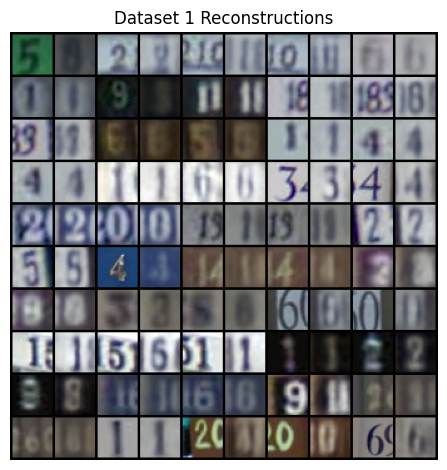

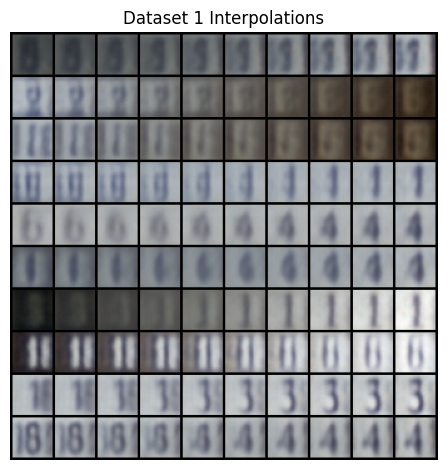

In [13]:
q2_save_results('a', 1, q2_a)

Final -ELBO: 240.8667, Recon Loss: 210.0669, KL Loss: 30.7997


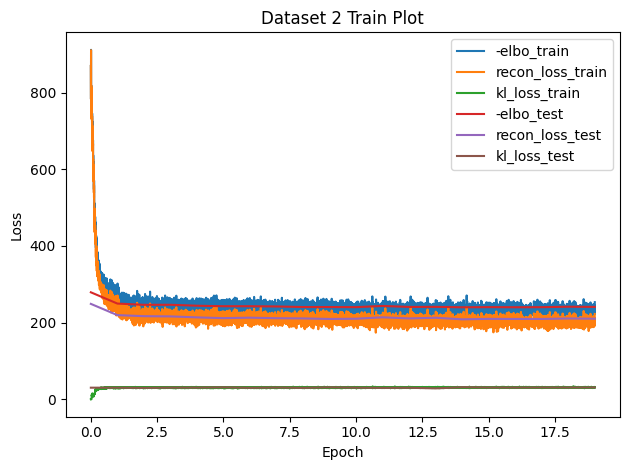

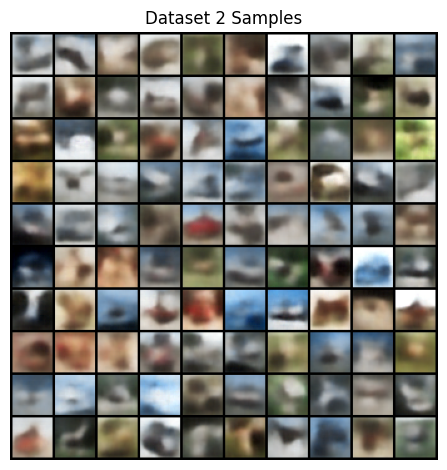

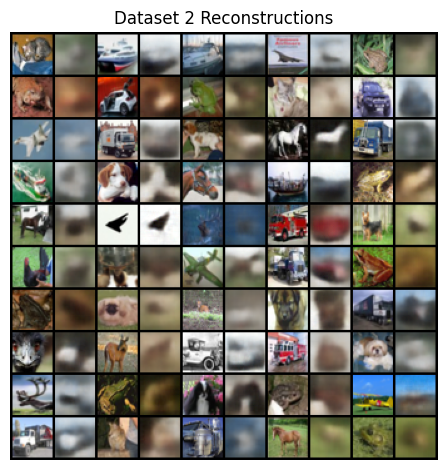

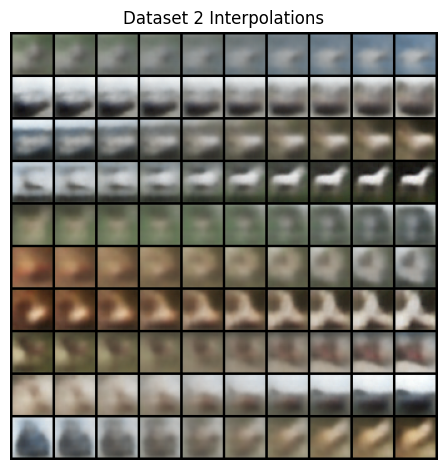

In [14]:
q2_save_results('a', 2, q2_a)

## Part (b) VAE with AF Prior
In this part, we will implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

We can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\theta(z)$ and scale parameters $\sigma_\theta(z)$ and do the following transformation on $z$:
$$\epsilon = z * \sigma_\theta(z) + \mu_\theta(z)$$
and optimize the objective
$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**Over the course of training, we will**


1.  record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)

In [15]:
class MaskedLinear(nn.Linear):
    """ same as Linear except has a configurable mask on the weights """

    def __init__(self, in_features, out_features, bias=True, conditional_size=None):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features)) # buffer of shape (in_features, out_features) to store the mask

        if conditional_size is not None: # None
            self.cond_op = nn.Linear(conditional_size, out_features)

    def set_mask(self, mask):
        # update the mask value for eack layer
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))

    def forward(self, input, cond=None):
        out = F.linear(input, self.mask * self.weight, self.bias)
        if cond is not None: # NOne
            out = out + self.cond_op(input)
        return out

class MADE(nn.Module):
    def __init__(self, input_shape, d, hidden_size=[512, 512], ordering=None,
                 conditional_size=None):
        super().__init__()
        self.input_shape = input_shape # 16
        self.nin = np.prod(input_shape) # 16
        self.nout = self.nin * d # 32
        self.d = d # 16
        self.hidden_sizes = hidden_size # [512, 512]
        self.ordering = np.arange(self.nin) if ordering is None else ordering # [0, 1, 2, 3, ...15]

        # define a simple MLP neural net
        self.net = []
        hs = [self.nin] + self.hidden_sizes + [self.nout]
        
        # Intialize Maksed MLP + ReLU layer (16--> 512-->512-->32)
        for h0, h1 in zip(hs, hs[1:]):
            self.net.extend([
                MaskedLinear(h0, h1, conditional_size=conditional_size),
                nn.ReLU(),
            ])
        self.net.pop()  # pop the last ReLU for the output layer
        self.net = nn.ModuleList(self.net)

        self.m = {}
        self.create_mask()  # builds the initial self.m connectivity

    def create_mask(self):
        L = len(self.hidden_sizes) #2

        # sample the order of the inputs and the connectivity of all neurons
        self.m[-1] = self.ordering # m = {-1: array([0, 1, 2, ...15])
        
        '''
         
        We add a tag to every neuron from hidden layer 1 to output layer. 
        
        For the hidden layers, if a particular neuron has a tag of let's say 2 it implies that the particular 
        neuron expects information flow from input neuron 0, 1, 2. 
        
        For the output layer, if a particular neuron has a tag of let's say 2 it implies that the particular 
        neuron expects information from input neurons 0, 1.
        
        Tag generation:
        Input neurons are tagged from 0, 1,...,len(input_neurons)-1
        For every neuron in every hidden layer, we sample an interger from 0 (inclusive) and len(input_neurons) - 1 (exclusive). 
        This ensures that any neuron in any hidden layer doesn't have an information flow from last input neuron (as expected
        from autoregressive models)
        
        '''
        # Generating tags for neurons in each hidden layer
        for l in range(L):
            self.m[l] = np.random.randint(self.m[l - 1].min(),
                                          self.nin - 1, size=self.hidden_sizes[l])
        
        # self.m[0] -> (512,) numbers betweem 0 (inclusive) and 15 (exclusive)
        # self.m[1] -> (512,)  numbers betweem 0 (inclusive) and 15 (exclusive)
        
        
        '''
        Mask Generation:
        Once we have the tags for every neuron in every hidden layer, 
        
        1. For connections between input to hidden layer and hidden to hidden layer
        is done based on the tag from the present and nect layer. For eg, if a neuron in the next layer has a tag of say 1, 
        (i.e. it's expecting information flow from input neurons 0, 1) then connection from neurons with tag as 1 from previous 
        layer is kept and all the connections with a tag of >=2 is masked out. 
        
        2. For connections between the hidden layer and output layer, for 0th neuron in the output layer we allow 
        connections from the neurons in the previous layer with tag < 0. Similarly for 2nd neuron in the output layer we allow 
        connections from the neurons in the previous layer with tag < 2 (i.e. allowing information flow from input neurons 0 and 1).
        
        This ensures that we have auto regressive nature of the model.
        '''
        
        # construct the mask matrices
        masks = [self.m[l - 1][:, None] <= self.m[l][None, :] for l in range(L)]
        masks.append(self.m[L - 1][:, None] < self.m[-1][None, :])
        '''    
        masks(inp-->hidden) - (16, 512)
        masks(hidden-->hidden) - (512, 512)
        masks(hidden-->output) - (512, 16)
        '''

        # masks(hidden-->output) - (512, 32) # same mask is copied, for every dim we have two output mean and std
        masks[-1] = np.repeat(masks[-1], self.d, axis=1)

        # set the masks in all MaskedLinear layers
        layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
        # set the mask for each MaksedLinear Layer
        for l, m in zip(layers, masks):
            l.set_mask(m)

    def forward(self, x, cond=None):
        batch_size = x.shape[0]
        out = x.view(batch_size, self.nin)
        for layer in self.net:
            if isinstance(out, MaskedLinear):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        out = out.view(batch_size, self.nin, self.d)
        return out

class AFVAE(nn.Module):
    def __init__(self, input_shape, latent_size):
        super().__init__()
        assert len(input_shape) == 3
        self.input_shape = input_shape # (3, 32, 32)
        self.latent_size = latent_size # 16

        self.made = MADE(latent_size, 2, hidden_size=[512, 512]) # initialize MADE
        self.encoder = ConvEncoder(input_shape, latent_size) # initialize encoder
        self.decoder = ConvDecoder(latent_size, input_shape) # initialize decoder

    def loss(self, x):
        # preprocessing
        x = 2 * x.float() - 1
        mu_z, log_std_z = self.encoder(x) # (bs, 16), (bs, 16)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z # sample z from Gaussian using predicted mean and std
        x_recon = self.decoder(z) #(bs, 3, 32, 32) # reconstruction

        recon_loss = F.mse_loss(x_recon, x, reduction='none').view(x.shape[0], -1).sum(1).mean() # reconstruction loss
        
        # log[q(z/x)]
        enc_log_prob = -0.5 * np.log(2 * np.pi) - log_std_z - 0.5 * (z - mu_z) ** 2 * torch.exp(-2 * log_std_z)
        
        # z --> x transformation
        out = self.made(z)
        mu, log_std = out.chunk(2, dim=-1) #(bs, 16), (bs, 16)
        log_std = torch.tanh(log_std)
        mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
        eps = z * torch.exp(log_std) + mu # eps = z*mu + std
        
        #log(p(Z)) = log(p(eps)) + log (det(de/dz))
        prior_log_prob = -0.5 * np.log(2 * np.pi) + log_std - 0.5 * eps ** 2
        
        # log q(z/x) - logp(z)
        kl_loss = (enc_log_prob - prior_log_prob).sum(1).mean()
        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_size).cuda() # (100, 16) sample 100 eps from normal distribution 
            # Pass this to MADE one to predict z in autoregressive fashion
            for i in range(self.latent_size):
                mu, log_std = self.made(z)[:, i].chunk(2, dim=-1)
                log_std = torch.tanh(log_std)
                mu, log_std = mu.squeeze(-1), log_std.squeeze(-1)
                z[:, i] = (z[:, i] - mu) * torch.exp(-log_std) # z = (eps - mu)/std
            # decode z and do inverse of preprocessing
            return self.decoder(z).cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5
     


In [16]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """


    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32') # (10000, 3, 32, 32)
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32') # (5000, 3, 32, 32)

    model = AFVAE((3, 32, 32), 16).cuda() #initialize autoregressive flow VAE
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3), quiet=True)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)
    samples = model.sample(100) * 255

    # sample 50 images in test test loader, encode and decode it back
    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z = model.encoder(2 * x - 1)[0]
        x_recon = model.decoder(z).cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    # sample images from test loader, encode, interpolate latent codes and decode
    x = next(iter(test_loader))[:20].cuda()
    with torch.no_grad():
        x = 2 * x - 1
        z, _ = model.encoder(x)
        z1, z2 = z.chunk(2, dim=0)
        interps = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interps = torch.stack(interps, dim=1).view(-1, 3, 32, 32)
        interps = torch.clamp(interps, -1, 1) * 0.5 + 0.5
    interps = interps.permute(0, 2, 3, 1).cpu().numpy() * 255

    samples, reconstructions, interps = np.clip(samples, 0, 255), np.clip(reconstructions, 0, 255), np.clip(interps, 0, 255)

    return train_losses, test_losses, samples, reconstructions, interps
     

Final -ELBO: 103.0283, Recon Loss: 79.1006, KL Loss: 23.9276


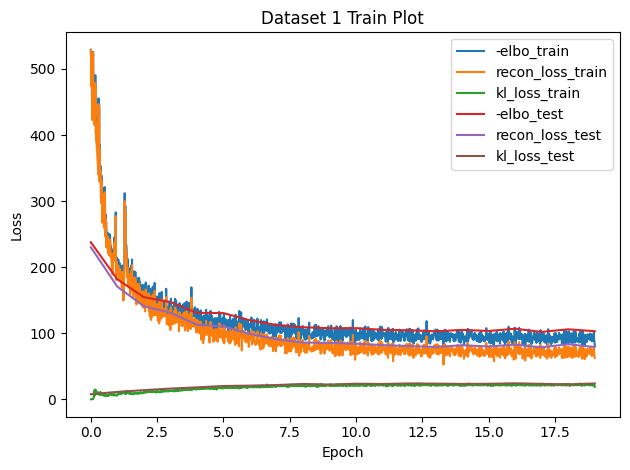

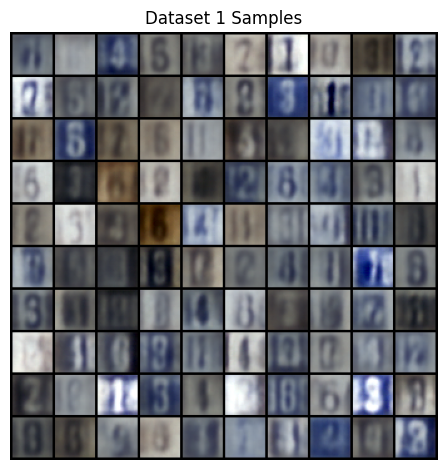

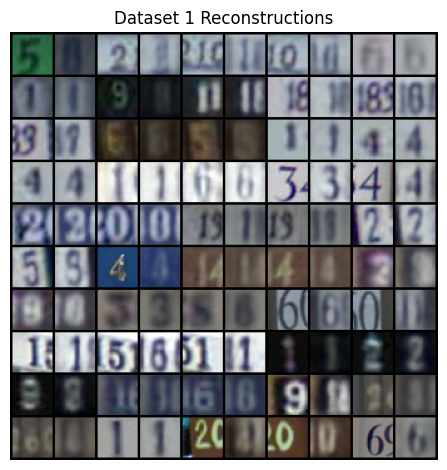

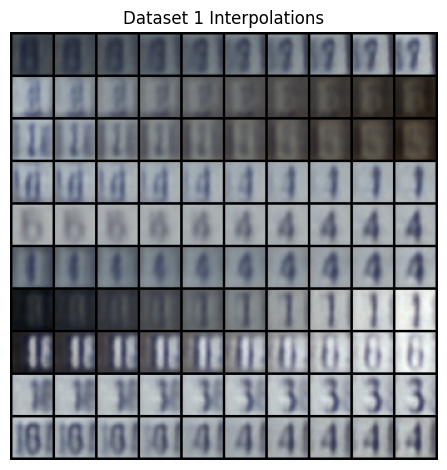

In [17]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# VQ-VAE
In this question, we will train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

Following designs for the VQ-VAE architecture are used in this expriment.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   A codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector is used
*   We initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   We use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   We center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, we implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, we will also need to train a PixelCNN prior on the categorical latents in order to sample.

**Over the course of training, we will**


1.  record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )
      
    def forward(self, x):
        return x + self.net(x)

class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()


class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, conditional_size=None, **kwargs):
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

        if conditional_size is not None:
            self.cond_op = nn.Linear(conditional_size, self.out_channels)

    def forward(self, input, cond=None):
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        if cond is not None:
            cond = self.cond_op(cond)
            out = out + cond.view(cond.shape[0], self.out_channels, 1, 1)
        return out

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        
          
        '''
        This creates a type A mask - prevents info flow from the pixel location [3, 3]
        which model is trying to predict
        
        [[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]
        '''
        
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        
        '''
        Type B mask: has the info flow from pixel location [3, 3] which model is 
        trying to predict

        [[1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]
        '''  
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1


class PixelCNNResBlock(nn.Module):
    def __init__(self, dim, conditional_size=None):
        super().__init__()
        self.block = nn.ModuleList([
            LayerNorm(dim),
            nn.ReLU(),
            MaskConv2d('B', dim, dim // 2, 1, conditional_size=conditional_size),
            LayerNorm(dim // 2),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim // 2, 3, padding=1, 
                       conditional_size=conditional_size),
            LayerNorm(dim // 2),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim, 1, conditional_size=conditional_size)
        ])

    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            if isinstance(layer, MaskConv2d):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return x + out


class PixelCNN(nn.Module):
    def __init__(self, input_shape, code_size, dim=256, n_layers=7,
                 conditional_size=None):
        super().__init__()
        
        # conditional_size = None
        
        # embedding matrix of shape (128, 128)
        self.embedding = nn.Embedding(code_size, dim)
        model = nn.ModuleList([MaskConv2d('A', dim, dim, 7, padding=3,
                                          conditional_size=conditional_size),
                               LayerNorm(dim), nn.ReLU()])
        
        # 9 layers of 10 residual blocks of Type B Conv2d
        for _ in range(n_layers - 1):
            model.append(PixelCNNResBlock(dim, conditional_size=conditional_size))
        # followed by LayerNorm, Type B Mask COnv2d and Relu
        model.extend([LayerNorm(dim), nn.ReLU(), MaskConv2d('B', dim, 512, 1, conditional_size=conditional_size),
                      nn.ReLU(), MaskConv2d('B', 512, code_size, 1,
                                            conditional_size=conditional_size)])
        self.net = model
        self.input_shape = input_shape
        self.code_size = code_size

    def forward(self, x, cond=None):
        # self.embedding(x) --> (128, 8, 8, 128)
        out = self.embedding(x).permute(0, 3, 1, 2).contiguous() # (128, 128, 8, 8)
        for layer in self.net:
            if isinstance(layer, MaskConv2d) or isinstance(layer, PixelCNNResBlock):
                out = layer(out, cond=cond)
            else:
                out = layer(out)
        return out # (128, 8, 8, 128) # every pixel location can take 128 possible values

    def loss(self, x, cond=None):
        return OrderedDict(loss=F.cross_entropy(self(x, cond=cond), x))

    def sample(self, n, cond=None):
        # tensor of zeros (128, 8, 8)
        samples = torch.zeros(n, *self.input_shape).long().cuda()
        # Get the prediction of first location, initiaize it back and feed to the netwrok again
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples, cond=cond)[:, :, r, c]
                    logits = F.softmax(logits, dim=1)
                    samples[:, r, c] = torch.multinomial(logits, 1).squeeze(-1)
        return samples


class Quantize(nn.Module):

    def __init__(self, size, code_dim):
        super().__init__()
        self.embedding = nn.Embedding(size, code_dim) # embedding matrix code book of shape (128, 256)
        self.embedding.weight.data.uniform_(-1./size,1./size) # initizalize the code book with sampled from Uniform (-1/128, 1/128)

        self.code_dim = code_dim # 128
        self.size = size # 256

    def forward(self, z):
        b, c, h, w = z.shape # (128, 256, 8, 8)
        weight = self.embedding.weight # code book: (128, 256)
        
        # flatten z -> (128*8*8, 128) = (8192, 128)
        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.code_dim)
        
        # calculate L2 norm between each z and all the codes in the codebook (z - codebook)^2
        distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
                    - 2 * torch.mm(flat_inputs, weight.t()) \
                    + (weight.t() ** 2).sum(dim=0, keepdim=True) # (8192, 128)
         
        # index of the code with min distance for each of z    
        encoding_indices = torch.max(-distances, dim=1)[1] # (8192)
        encoding_indices = encoding_indices.view(b, h, w) # (128, 8, 8) 2d tensor with indices of codes
        # quntized codes for all z -> (128, 256, 8, 8)
        quantized = self.embedding(encoding_indices).permute(0, 3, 1, 2).contiguous()

        # Zq = Z + (Zq-Z) where we don;t consider gradient from (Zq-Z). Therefore in backprop 
        # for the operation Z --> Zq is considered as 1
        
        # returns code vectors (quztized z vectors), Zq (calculated in a way such that gradient Z --> Zq is 1) and indices of codes
        return quantized, (quantized - z).detach() + z, encoding_indices


class VectorQuantizedVAE(nn.Module):
    def __init__(self, code_dim, code_size):
        super().__init__()
        self.code_size = code_size # 128
        
        # encoder block - series of Conv2d and residual block. Output of enocder z is of shape (128, 256, 8, 8)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, stride=2, padding=1), # (128, 256, 16, 16)
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, stride=2, padding=1), #(128, 256, 8, 8)
            ResidualBlock(256),
            ResidualBlock(256),
        )

        self.codebook = Quantize(code_size, code_dim) # returns Zq, Z and indices of Zq
        
        # series of residual block and transpose Conv2d. Output of decoder x_tilda is of shape (128, 3, 32, 32)
        self.decoder = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),
            nn.Tanh(), # note that last layer is tankh so that all values are between (-1, 1) (as input values were scales and shifted to (-1, 1)
        )

    def encode_code(self, x):
        '''
        Map x to (-1, 1), encode, quantize and return the indices of Zq from the codebook
        # (128, 8, 8)
        '''
        with torch.no_grad():
            x = 2 * x - 1
            z = self.encoder(x)
            indices = self.codebook(z)[2]
            return indices

    def decode_code(self, latents):
        with torch.no_grad():
            # get the Zq from the indices
            latents = self.codebook.embedding(latents).permute(0, 3, 1, 2).contiguous()
            return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5 # decode and do reverse of pre-processing

    def forward(self, x):
        z = self.encoder(x) # (128, 256, 8, 8)
        # quantize z
        e, e_st, _ = self.codebook(z) # Zq: (128, 256, 8, 8), Zq (calculated in a way such that gradient Z --> Zq is 1): (128, 256, 8, 8), indices of code: (128, 8, 8)
        x_tilde = self.decoder(e_st) #  # pass Zq (calculated in a way such that gradient Z --> Zq is 1) to the decoder so that suring backprop Z --> Zq is 1 
        
        # mean losses  -> a floating point
        diff1 = torch.mean((z - e.detach()) ** 2) # loss to make Z close to Zq with Zq fixed (we use .detach() so that gradient of Zq is not considered)
        diff2 = torch.mean((e - z.detach()) ** 2) # loss to make Zq close to Z with Z fixed
        return x_tilde, diff1 + diff2 # returns reconstructed x and part of loss

    def loss(self, x):
        x = 2 * x - 1 # cantre and scale the images so that all va;ues are from (-1, 1)
        x_tilde, diff = self(x)  # (128, 3, 32, 32), # floatinh point
        recon_loss = F.mse_loss(x_tilde, x) # averaged reconstruction loss
        loss = recon_loss + diff # total loss
        return OrderedDict(loss=loss, recon_loss=recon_loss, reg_loss=diff)

In [5]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples (an equal number from each class) with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32') # (10000, 3, 32, 32)
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32') # (5000, 3, 32, 32)

    code_dim, code_size = 256, 128 # dim per code, num of codes
    vqvae = VectorQuantizedVAE(code_dim, code_size).cuda()
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_epochs(vqvae, train_loader, test_loader,
                                             dict(epochs=20, lr=1e-3, grad_clip=1), quiet=True)
    vqvae_train_losses, vqvae_test_losses = train_losses['loss'], test_losses['loss']

    def create_prior_dataset(data_loader):
        prior_data = []
        with torch.no_grad():
            for x in data_loader:
                x = x.cuda()
                z = vqvae.encode_code(x) # (128, 8, 8) # indices of Zq from the code book
                prior_data.append(z.long()) # appends it to the list
        return torch.cat(prior_data, dim=0) # (total_train_samples, 8, 8)
    
    # Initialize prior as Pixel CNN and train over Zq
    prior = PixelCNN(code_size=code_size, input_shape=(8, 8), dim=128, n_layers=10).cuda()
    
    prior_train_data, prior_test_data = create_prior_dataset(train_loader), create_prior_dataset(test_loader) # (total_test_samples, 8, 8), (total_test_samples, 8, 8)
    
    # create dataloaders
    prior_train_loader = data.DataLoader(prior_train_data, batch_size=128, shuffle=True)
    prior_test_loader = data.DataLoader(prior_test_data, batch_size=128)
    
    prior_train_losses, prior_test_losses = train_epochs(prior, prior_train_loader, prior_test_loader,
                                                         dict(epochs=15, lr=1e-3, grad_clip=1), quiet=True)
    prior_train_losses, prior_test_losses = prior_train_losses['loss'], prior_test_losses['loss']

    samples = prior.sample(100).long() # sample Z of shape (100, 8, 8), inidces 
    samples = vqvae.decode_code(samples) * 255 # 
    
    # reconstructions
    x = next(iter(test_loader))[:50].cuda()
    with torch.no_grad():
        z = vqvae.encode_code(x)
        x_recon = vqvae.decode_code(z)
    x = x.cpu().permute(0, 2, 3, 1).numpy()
    reconstructions = np.stack((x, x_recon), axis=1).reshape((-1, 32, 32, 3)) * 255

    return vqvae_train_losses, vqvae_test_losses, prior_train_losses, prior_test_losses, samples, reconstructions

VQ-VAE Final Test Loss: 0.1495
PixelCNN Prior Final Test Loss: 2.1410


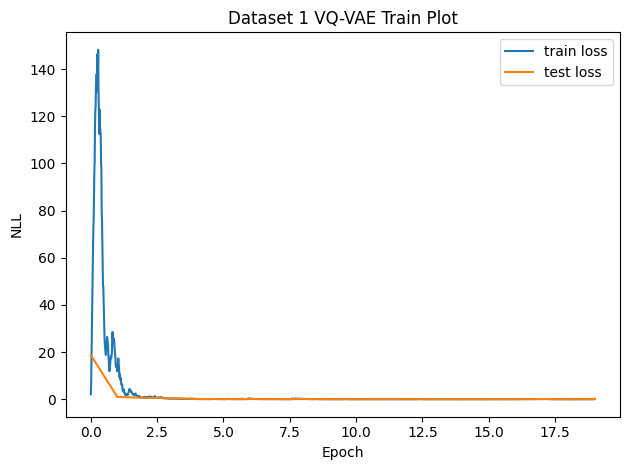

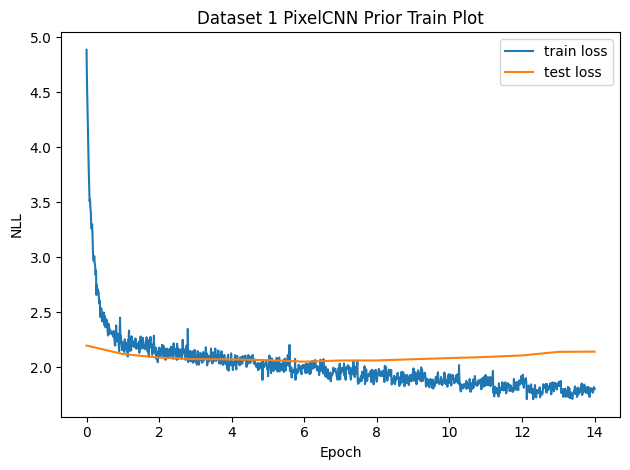

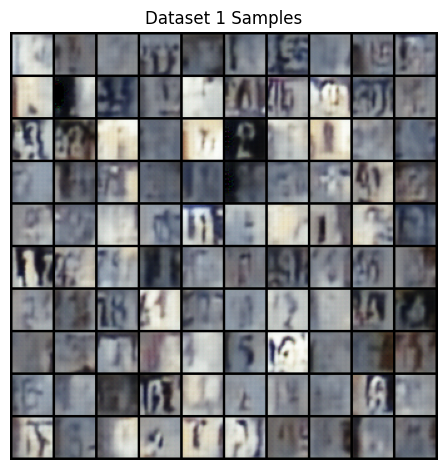

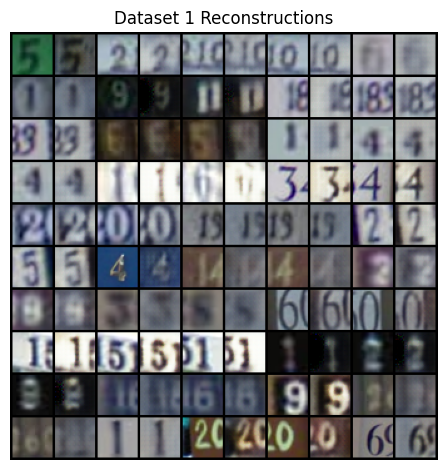

In [6]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)